# <span style="color:darkslateblue">Exploratory Data Analysis</span>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gc

%matplotlib inline

In [2]:
# List of matplotlib colors to use in iteration
mat_colors = ["teal", "olive", "blue", "maroon", "green", "purple", "red", "orangered", "tan"] 

## <span style="color:indianred">Reading Files</span>

`train_transaction.csv` contains labeled transactions for training <br>
`train_identity.csv` contains device info corresponding to train transactions <br>
`test_transaction.csv` contains transactions for testing model <br>
`test_identity.csv` contains device info corresponding to test transactions <br>

In [3]:
# loading , nrows=10000
train_tr = pd.read_csv("data/train_transaction.csv")
train_id = pd.read_csv("data/train_identity.csv")
test_tr  = pd.read_csv("data/test_transaction.csv")
test_id  = pd.read_csv("data/test_identity.csv")

In [4]:
# find percentage of rows with device info
print(np.sum(train_tr["TransactionID"].isin(train_id["TransactionID"].unique())) / len(train_tr))
print(np.sum( test_tr["TransactionID"].isin( test_id["TransactionID"].unique())) / len( test_tr))

0.2442391709283029
0.28006615471756946


In [5]:
train_tr.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <span style="color:indianred">Time Series Analysis</span>

The train and test data appear to be split by time. There is a slight gap inbetween, but otherwise the training set is from an earlier period of time and test is from a later period of time.

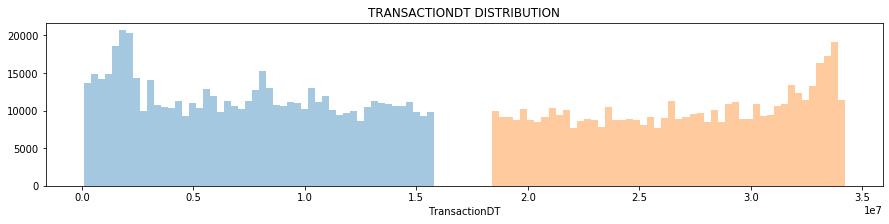

In [6]:
plt.figure(figsize=(15,3))
plt.title("TRANSACTIONDT DISTRIBUTION")

ax = sns.distplot(train_tr.TransactionDT, kde=False, hist=True)
ax = sns.distplot(test_tr.TransactionDT, kde=False, hist=True)

## <span style="color:indianred">isFraud</span>

The fraud transactions in the dataset are very much lesser in count than the non-fraud transactions

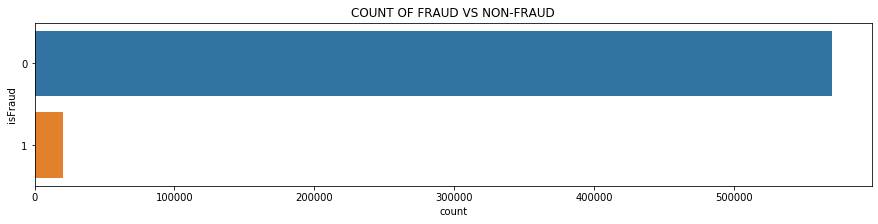

In [7]:
plt.figure(figsize=(15,3))
plt.title("COUNT OF FRAUD VS NON-FRAUD")

ax = sns.countplot(y="isFraud", data=train_tr)

## <span style="color:indianred">TransactionAmt</span>

Since the data was skewed to right, log transform was used to center the data over orders of magnitudes. <br>
It seems that the mean fraud transaction amount is higher than non-fraud transaction amount.

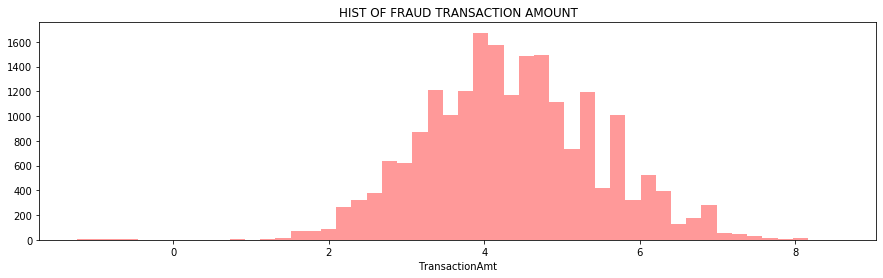

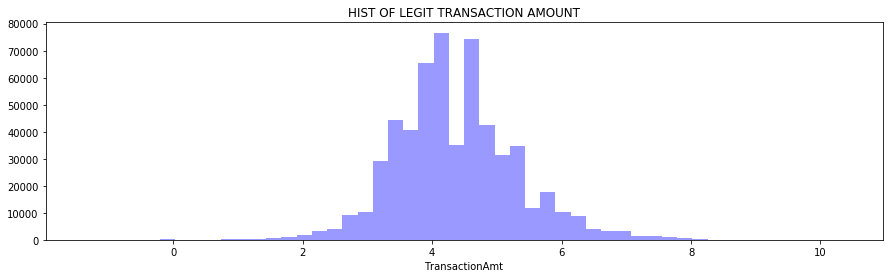

In [8]:
plt.figure(figsize=(15,4))
plt.title("HIST OF FRAUD TRANSACTION AMOUNT")
ax = sns.distplot(train_tr.loc[train_tr["isFraud"]==1].TransactionAmt.apply(np.log), color="r", kde=False)

plt.figure(figsize=(15,4))
plt.title("HIST OF LEGIT TRANSACTION AMOUNT")
ax = sns.distplot(train_tr.loc[train_tr["isFraud"]==0].TransactionAmt.apply(np.log), color="b", kde=False)

In [9]:
print("Mean fraud amount : %.2f"%train_tr.loc[train_tr["isFraud"] == 1].TransactionAmt.mean())
print("Mean legit amount : %.2f"%train_tr.loc[train_tr["isFraud"] == 0].TransactionAmt.mean())

Mean fraud amount : 149.24
Mean legit amount : 134.51


## <span style="color:indianred">ProductCD</span>

In the overall training data, W and C counts are high. <br>
When the percentage of fraud from each product is taken into consideration, C dominates. <br>

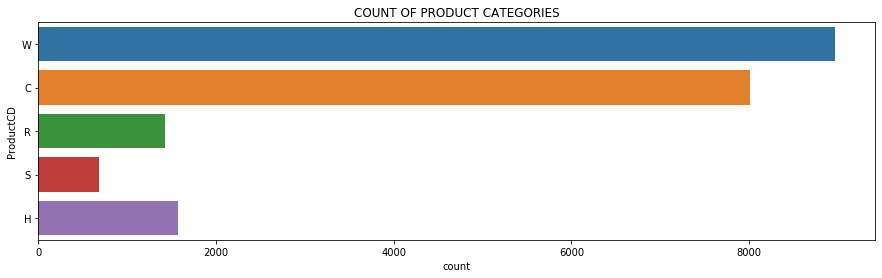

In [10]:
plt.figure(figsize=(15,4))
plt.title("COUNT OF PRODUCT CATEGORIES")

ax = sns.countplot(y=train_tr.loc[train_tr["isFraud"] == 1].ProductCD)

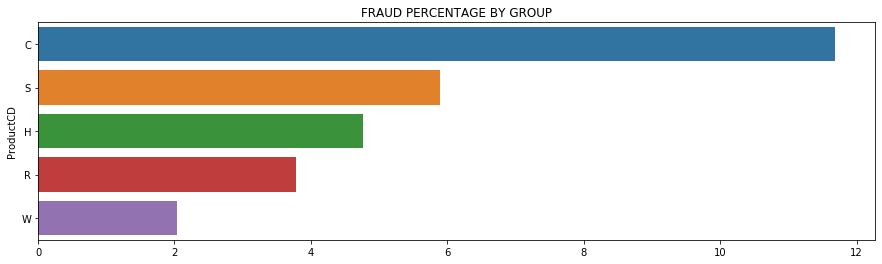

In [11]:
plt.figure(figsize=(15,4))
plt.title("FRAUD PERCENTAGE BY GROUP")

percent = (train_tr.groupby("ProductCD")["isFraud"].mean()*100).sort_values(ascending=False)
ax = sns.barplot(y=percent.index, x=percent.values)

del percent

## <span style="color:indianred">card_1 - card_6</span>

card_1 to card_6 are given to be categorical, even though some appear continuous <br>
card_4 seems to represent vendor company <br>
card_6 seems to represent the card type (credit or debit) <br>

In [12]:
card_cols = [c for c in train_tr.columns if "card" in c]
train_tr[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


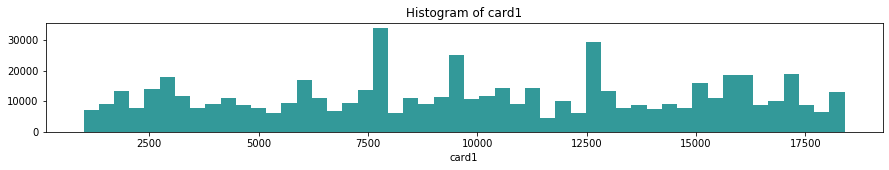

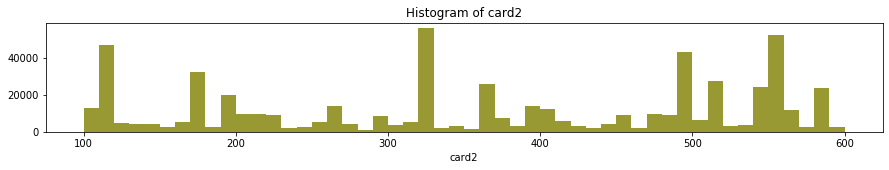

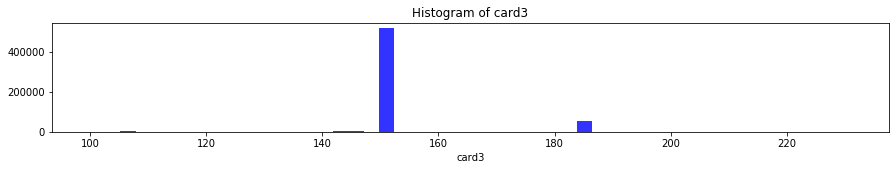

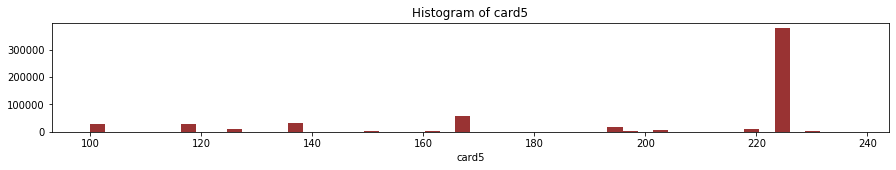

In [13]:
color_id = 0

for col in ["card1", "card2", "card3", "card5"]:
    # set individual figure for each column
    plt.figure(figsize=(15, 2))
    plt.title("Histogram of " + str(col))
    
    ax = sns.distplot(train_tr[col], kde=False, color=mat_colors[color_id], hist_kws={"alpha":0.8})
    
    # update color index
    color_id = (color_id + 1) % len(mat_colors)

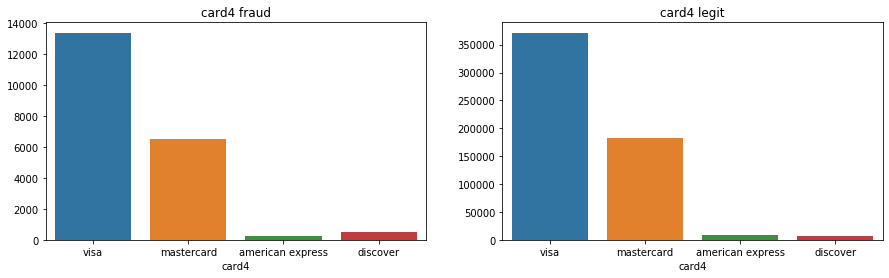

In [14]:
# card4 fraud vs non-fraud
card4_group = train_tr.groupby("card4")["isFraud"]
card4_order = train_tr["card4"].value_counts().index

card4_fr = card4_group.sum()
card4_lg = card4_group.count() - card4_fr

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
ax = sns.barplot(card4_fr.index, card4_fr.values, ax=axes[0], order = card4_order).set_title("card4 fraud")
ax = sns.barplot(card4_lg.index, card4_lg.values, ax=axes[1], order = card4_order).set_title("card4 legit")

del card4_group, card4_order, card4_fr, card4_lg, fig, axes

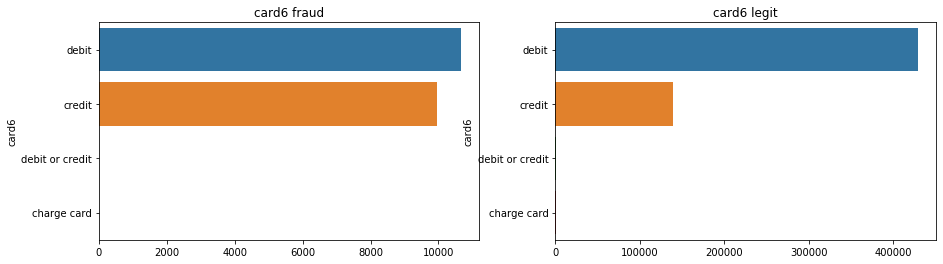

In [15]:
# card6 fraud vs non-fraud
card6_group = train_tr.groupby("card6")["isFraud"]
card6_order = train_tr["card6"].value_counts().index

card6_fr = card6_group.sum()
card6_lg = card6_group.count() - card6_fr

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
ax = sns.barplot(y=card6_fr.index, x=card6_fr.values, ax=axes[0], order = card6_order).set_title("card6 fraud")
ax = sns.barplot(y=card6_lg.index, x=card6_lg.values, ax=axes[1], order = card6_order).set_title("card6 legit")

del card6_group, card6_order, card6_fr, card6_lg, fig, axes

## <span style="color:indianred">P and R emaildomain</span>

These represent purchaser and recipient email domains <br>

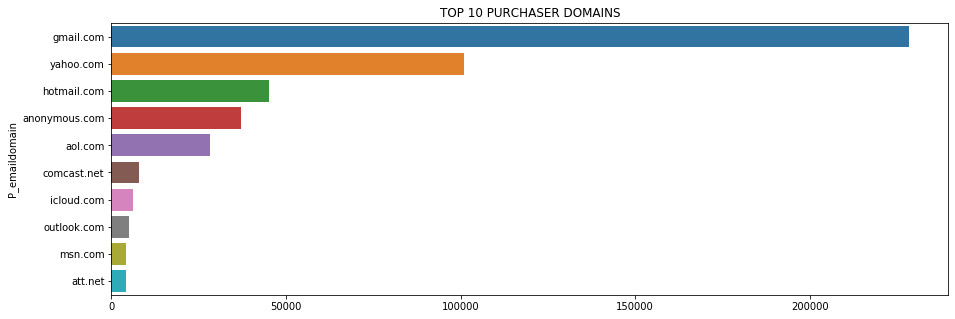

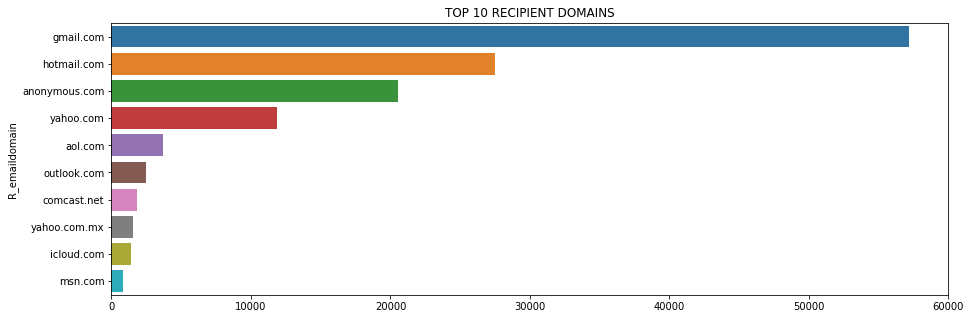

In [16]:
# get top 10 recurring domains
top_p_domains = train_tr.groupby("P_emaildomain")["TransactionID"].count().sort_values(ascending=False).head(10)
top_r_domains = train_tr.groupby("R_emaildomain")["TransactionID"].count().sort_values(ascending=False).head(10)

plt.figure(figsize=(15, 5))
plt.title("TOP 10 PURCHASER DOMAINS")
ax = sns.barplot(y=top_p_domains.index, x=top_p_domains.values)

plt.figure(figsize=(15, 5))
plt.title("TOP 10 RECIPIENT DOMAINS")
ax = sns.barplot(y=top_r_domains.index, x=top_r_domains.values)

del top_p_domains, top_r_domains

## <span style="color:indianred">addr1 - addr2</span>

addr1 and addr2 columns are known to be categorical (description). <br>
They represent the address of customer, which is encoded or encrypted for security purposes <br>

In [17]:
print("addr1 contains %d missing values"%train_tr["addr1"].isna().sum())
print("addr2 contains %d missing values"%train_tr["addr2"].isna().sum())

addr1 contains 65706 missing values
addr2 contains 65706 missing values


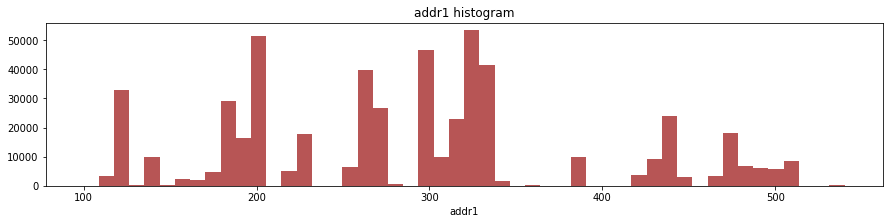

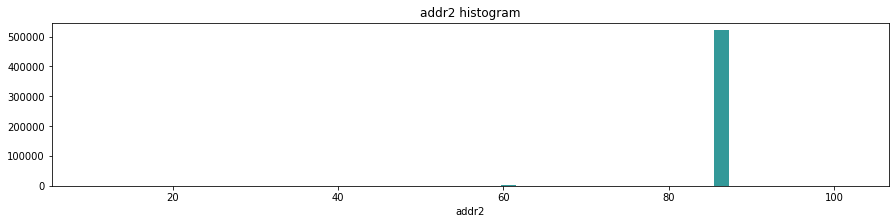

In [18]:
# addr1
plt.figure(figsize=(15, 3))
plt.title("addr1 histogram")
ax = sns.distplot(train_tr["addr1"], kde=False, color="brown", hist_kws={"alpha":0.8})

# addr2
plt.figure(figsize=(15, 3))
plt.title("addr2 histogram")
ax = sns.distplot(train_tr["addr2"], kde=False, color="teal", hist_kws={"alpha":0.8})

## <span style="color:indianred">dist1 - dist2</span>

dist1 and dist2 represent the distance between place of transaction and cardowner's home or work address. <br>
The histogram is justified because most of the transaction happens in the same address <br>

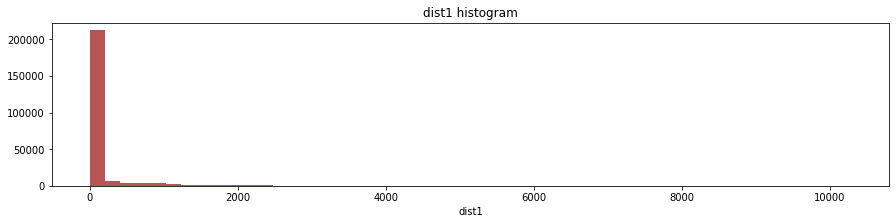

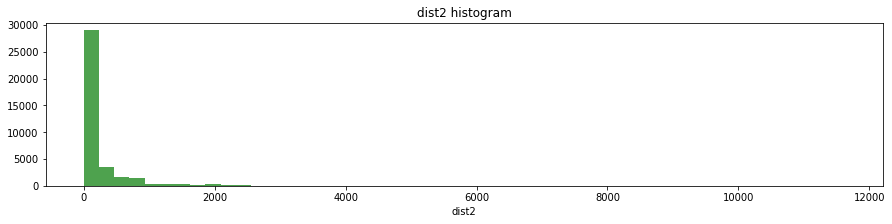

In [19]:
# dist1
plt.figure(figsize=(15, 3))
plt.title("dist1 histogram")
ax = sns.distplot(train_tr["dist1"], kde=False, color="brown", hist_kws={"alpha":0.8})

# dist2
plt.figure(figsize=(15, 3))
plt.title("dist2 histogram")
ax = sns.distplot(train_tr["dist2"], kde=False, color="forestgreen", hist_kws={"alpha":0.8})

## <span style="color:indianred">C1 - C14</span>

The columns C1 - C14 are known to be numerical. <br>
Heatmap can be generated to understand correlation between any two variables <br>

In [20]:
c_cols = [col for col in train_tr.columns if col[0] == 'C']
train_tr[c_cols].head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


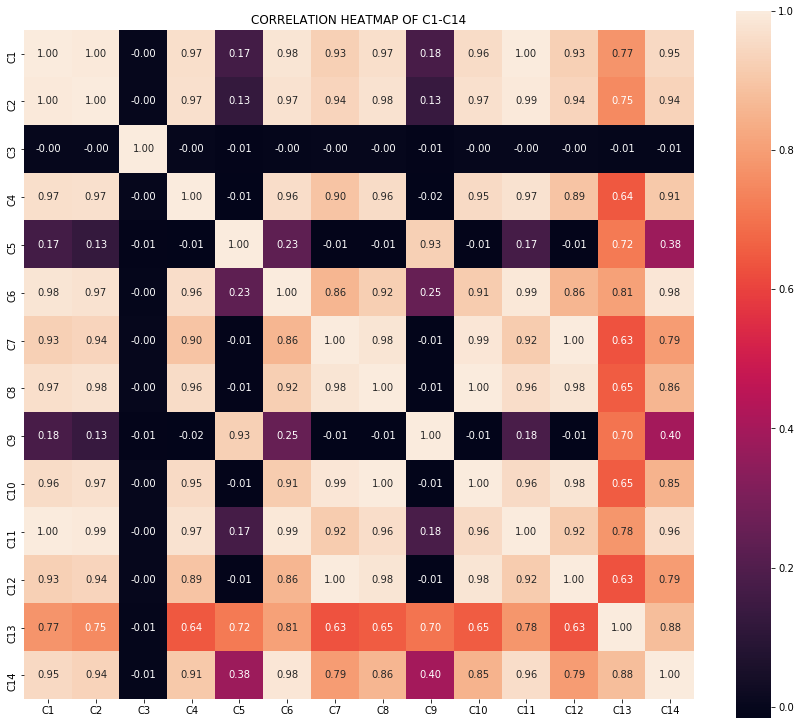

In [21]:
plt.figure(figsize=(15, 13))
plt.title("CORRELATION HEATMAP OF C1-C14")

ax = sns.heatmap(train_tr[c_cols].corr(), annot=True, fmt=".2f", square=True)

## <span style="color:indianred">D1 - D15</span>

The columns D1 to D15 are also known to be numerical. <br>
Similar heatmap can be generated to better understand correlation between variable pairs. <br>

In [22]:
d_cols = [col for col in train_tr.columns if col[0] == 'D' and col[1].isdigit()]
train_tr[d_cols].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


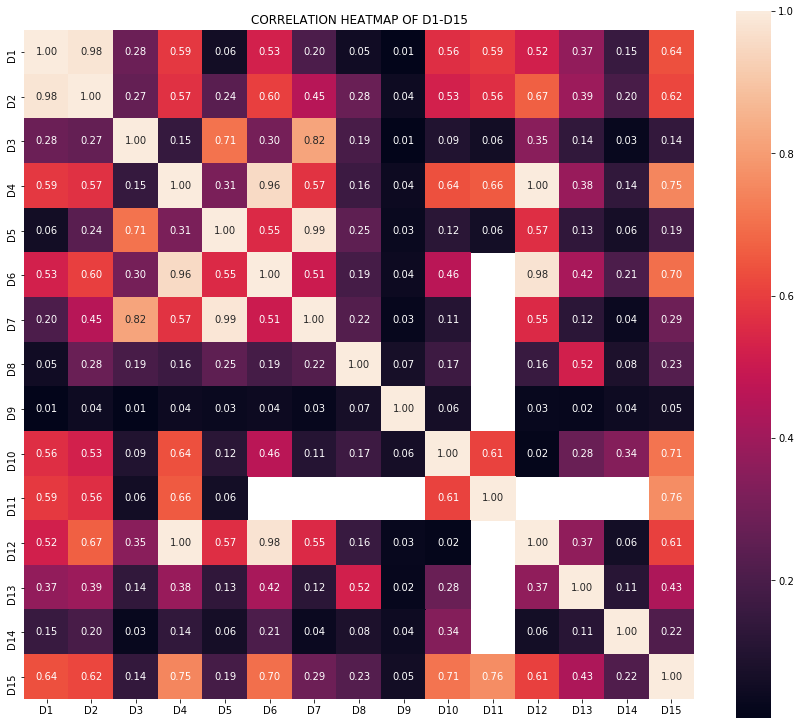

In [23]:
plt.figure(figsize=(15, 13))
plt.title("CORRELATION HEATMAP OF D1-D15")

ax = sns.heatmap(train_tr[d_cols].corr(), annot=True, fmt=".2f", square=True)

## <span style="color:indianred">M1 - M9</span>

These columns are given to be categorical <br>
M1-M9 except M4 contain - T, F or NaN <br>
M4 contains values  - M0, M1, M2 or NaN <br>

In [24]:
m_cols = [col for col in train_tr.columns if col[0] == 'M']
train_tr[m_cols].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


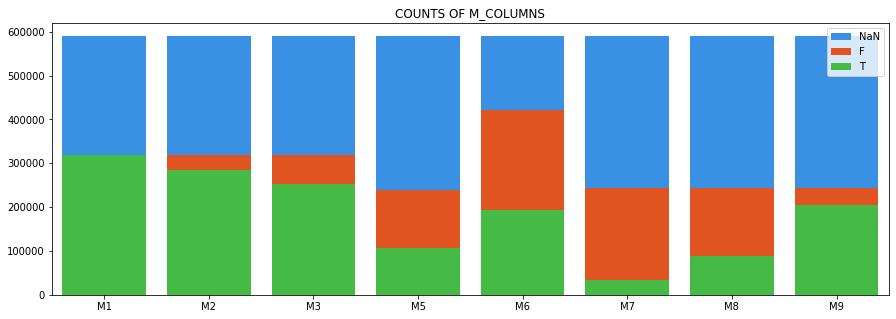

In [25]:
plt.figure(figsize=(15, 5))
plt.title("COUNTS OF M_COLUMNS")

# remove M4 from the list
m_cols = [col for col in m_cols if col != "M4"]

# tru=T, val=T+F, all=val+nan
m_val = train_tr[m_cols].count()
m_tru = (train_tr[m_cols] == 'T').sum()
m_all = train_tr[m_cols].isna().sum() + m_val

# plot
ax = sns.barplot(m_all.index, m_all.values, color="dodgerblue", label="NaN")
ax = sns.barplot(m_val.index, m_val.values, color="orangered", label="F")
ax = sns.barplot(m_tru.index, m_tru.values, color="limegreen", label="T")

# delete unused
del m_val, m_tru, m_all

# set legends and show
ax.legend(ncol = 1, loc = 'upper right')
plt.show()

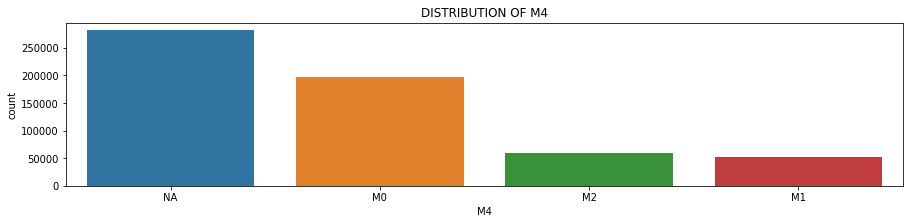

In [26]:
plt.figure(figsize=(15, 3))
plt.title("DISTRIBUTION OF M4")

# fill na with new category NA
train_tr["M4"] = train_tr["M4"].fillna("NA")

ax = sns.countplot(train_tr["M4"], order=train_tr["M4"].value_counts().index)

## <span style="color:indianred">V1 - V339</span>

These are Vesta engineered columns which are useful features obtained from transforming some features, which may or may not be given. <br>
Simple look at the data reveals that most of them are 0s and 1s with missing values and some larger values as well.

In [27]:
v_cols = [c for c in train_tr if c[0] == 'V']
train_tr[v_cols].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# create a new columnn with mean of all vs from a row
train_tr["v_mean"] = train_tr[v_cols].mean(axis=1)

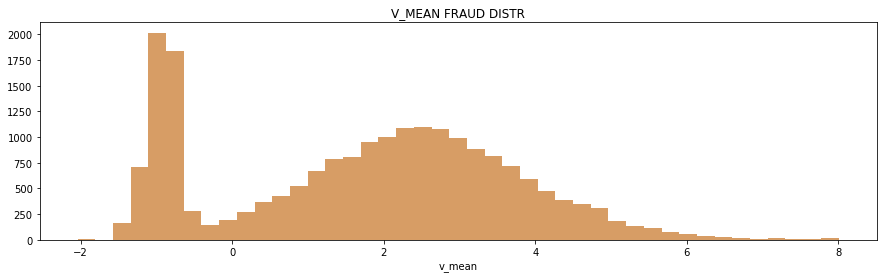

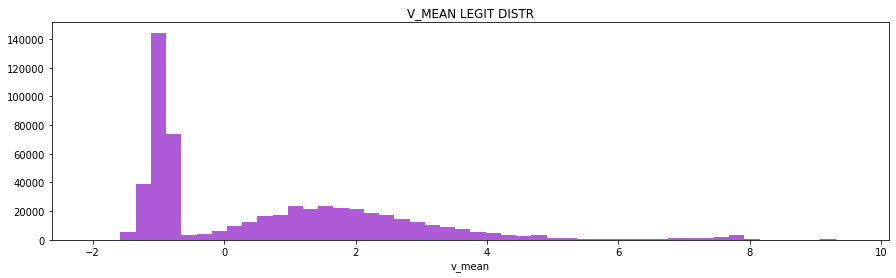

In [29]:
# group and calcuate
v_mean_fr = train_tr.loc[train_tr["isFraud"] == 1]["v_mean"].apply(np.log)
v_mean_lg = train_tr.loc[train_tr["isFraud"] == 0]["v_mean"].apply(np.log)

# plot
plt.figure(figsize=(15, 4))
plt.title("V_MEAN FRAUD DISTR")
ax = sns.distplot(v_mean_fr, color="peru", kde=False, hist_kws={"alpha":0.8})

plt.figure(figsize=(15, 4))
plt.title("V_MEAN LEGIT DISTR")
ax = sns.distplot(v_mean_lg, color="darkorchid", kde=False, hist_kws={"alpha":0.8})

del v_mean_fr, v_mean_lg

## <span style="color:indianred">DeviceType</span>

The percentage of fraud transactions done by mobile are more than that done by desktops. <br>

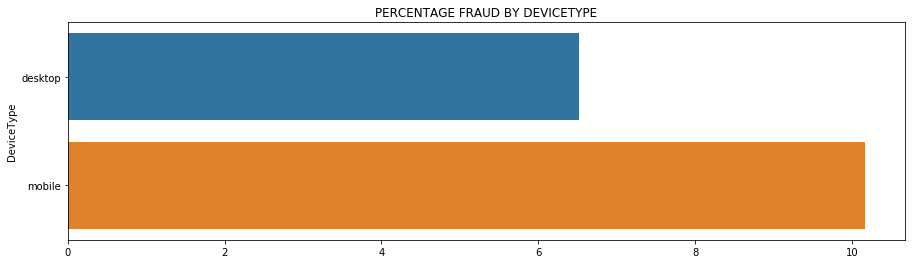

In [30]:
plt.figure(figsize=(15, 4))
plt.title("PERCENTAGE FRAUD BY DEVICETYPE")

if "DeviceType" not in train_tr.columns:
    train_tr = train_tr.merge(train_id[["TransactionID", "DeviceType"]], on="TransactionID")

device_mean = (train_tr.groupby("DeviceType")["isFraud"].mean()*100).sort_values()
ax = sns.barplot(y=device_mean.index, x=device_mean.values)

del device_mean

## <span style="color:indianred">DeviceInfo</span>

Without doubt, most transactions occur in Windows clients and iOS, mac follow. <br>

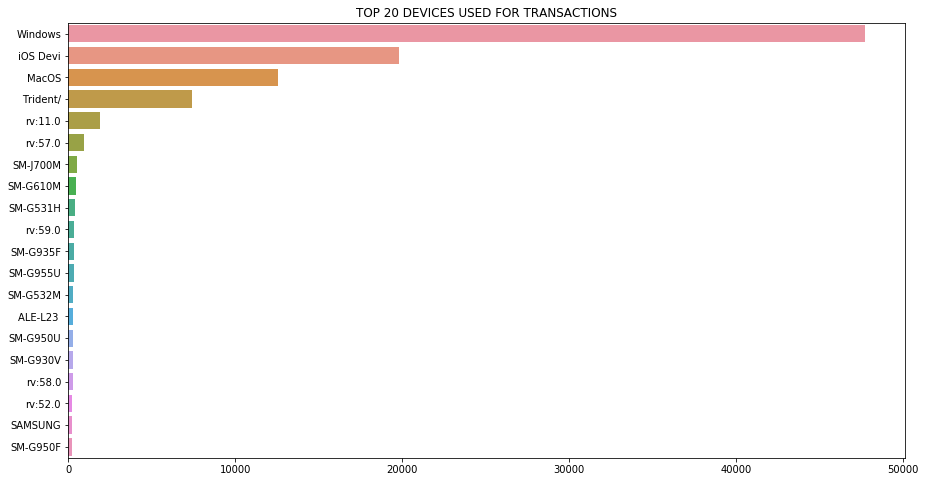

In [31]:
plt.figure(figsize=(15, 8))
plt.title("TOP 20 DEVICES USED FOR TRANSACTIONS")

# get top 20 recurring devices
top_device = train_id.groupby("DeviceInfo")["TransactionID"].count().sort_values(ascending=False).head(20)
top_device.index = [idx[:8] for idx in top_device.index]

ax = sns.barplot(y=top_device.index, x=top_device.values)

del top_device

## <span style="color:indianred">Some Interesting Data</span>

Plotting some columns that look interesting with respect to Transaction Date to compare Train and Test data values. <br>

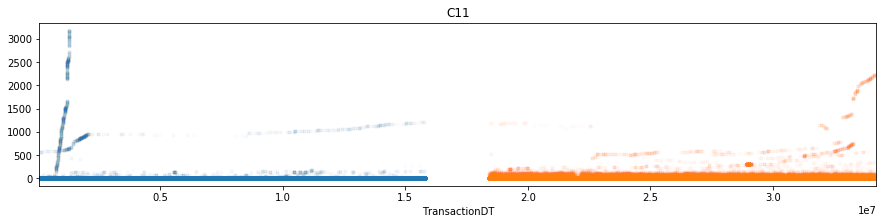

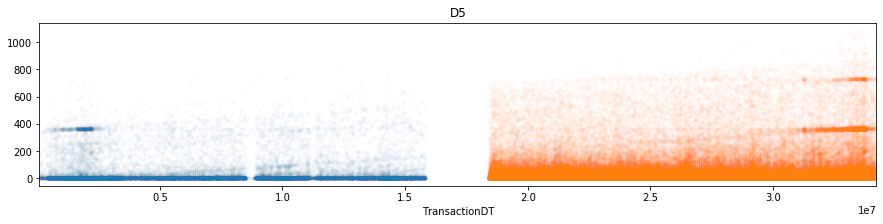

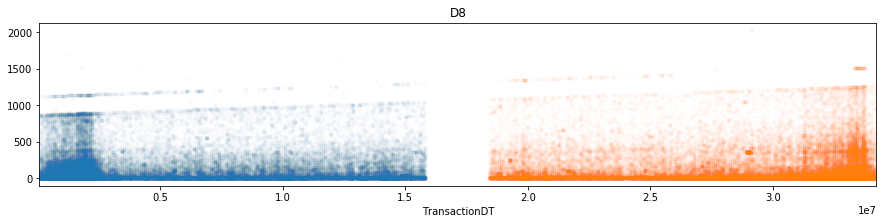

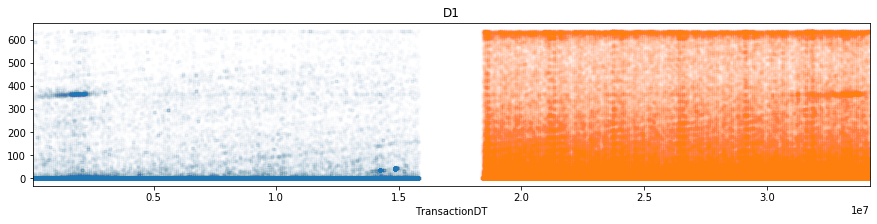

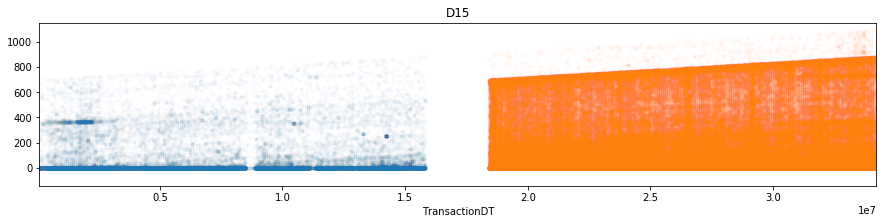

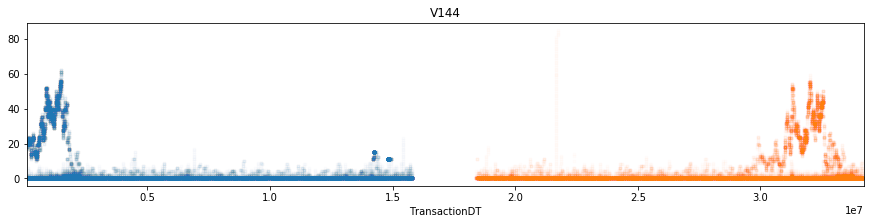

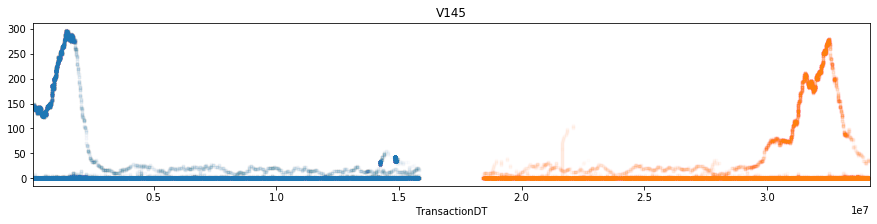

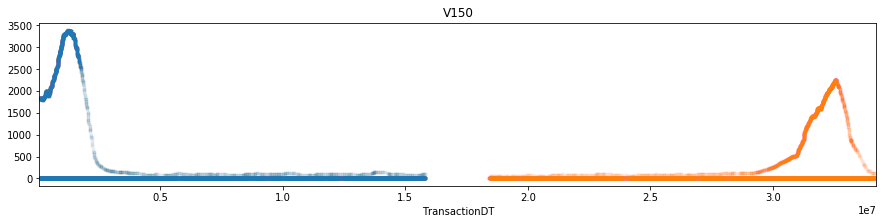

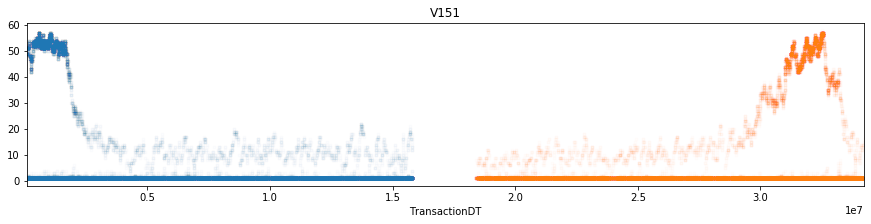

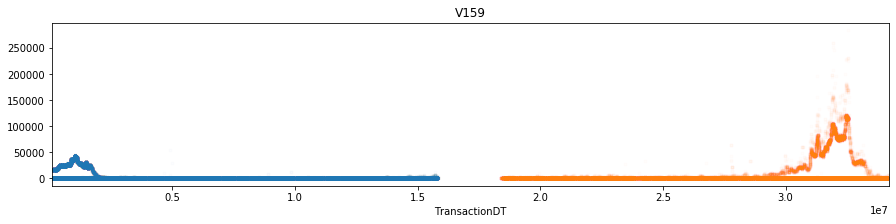

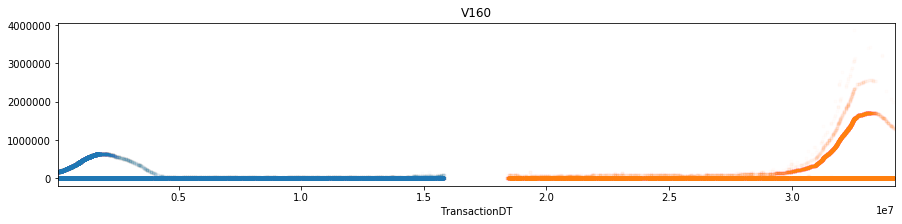

In [32]:
for col in ["C11", "D5", "D8", "D1", "D15", "V144", "V145", "V150", "V151", "V159", "V160"]:
    try:
        train_tr.set_index("TransactionDT")[col].plot(style='.', title=col, figsize=(15, 3), alpha=0.01)
        test_tr.set_index( "TransactionDT")[col].plot(style='.', title=col, figsize=(15, 3), alpha=0.01)
        plt.show()
    
    except TypeError:
        pass
    except KeyError:
        pass